## Create connection with Mongo

In [7]:
import pandas as pd
import numpy as np
import pymongo
from pymongo import MongoClient
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_splitfrom sklearn import metrics

In [ ]:
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('stopwords')

In [8]:
client = MongoClient('localhost', 27017)

### Client is the database
db = client['StockTwitClass101']

## Pipeline To create Sentiment

Related paper: [Intraday online investor sentiment and return patterns in the U.S.
stock market](https://docs.google.com/file/d/1L8bS8vNTXS-HWToP4zMpqfT308n-LxZb/edit)

L1/L2 Lexicon: [here](http://www.thomas-renault.com/data.php)

A) Create a Function to prepare the data
    
    1. Keep only twit with sentiment either `Bullish` or `Bearish` and remove multiple stock twits
   
    2. take negation into account, we add the prefix "negtag_" to all words following "not","no","none","neither","never" or “nobody”
    
    3. Convert digit to "_digit"
    
    4. Remove when mention a user
    
    5. lemmatize corpus
    
    6. Prepare train/test set
    
B) Build the Vectorization
C) Construct the Naive classifier
D) Predict out of sample

### note about Lemmatization

Lemmatization reduces words to their base word, which is linguistically correct lemmas. It transforms root word with the use of vocabulary and morphological analysis. Lemmatization is usually more sophisticated than stemming. Stemmer works on an individual word without knowledge of the context. For example, The word "better" has "good" as its lemma. This thing will miss by stemming because it requires a dictionary look-up


### Create a Function to prepare the data

Step : 1
       
       - Exclude multi tickers

Step : 2
       
       - take negation into account:
       
       - "not","no","none","neither","never" or “nobody”

Step : 3
       
       - Convert digit to "_digit"

Step : 4
        
       - Remove @USER

Step : 5
       
       - Remove unicode issue
        
Step 6: Lemmanize


In [9]:
def metatransformation(query, to_train=True):
    """
    Arguments:
    Query: MongoDB query 
    to_train:  True: return a train and test dataset
    False: return only data to predict out of sample
    
    Step : 1
        - Exclude multi tickers

    Step : 2
        - take negation into account:
        - "not","no","none","neither","never" or “nobody”

    Step : 3
        - Convert digit to "_digit"

    Step : 4
        - Remove @USER

    Step : 5
        - Remove unicode issue

    Step 6: Lemmanize


    """

    text = pd.DataFrame(list(db.messages.find(query)))

    # Count stock

    text["count_stock"] = text["symbols"].apply(lambda x: len(x))

    # Extract single count

    text = text[text["count_stock"].isin([1])]

    # text = df.copy()

    # take negation into account
    text["body_transform"] = text["body"].replace(
        regex={
            r"\bnothing\b": "nothing_negword",
            r"\bno\b": "no_negword",
            r"\bnone\b": "none_negword",
            r"\bneither\b": "neither_negword",
            r"\bnever\b": "never_negword",
            r"\bnobody\b": "nobody_negword",
        }
    )

    # Convert digit to "_digit"
    # Remove @USER
    # Remove unicode issue
    # Remove ticker
    # Remove all the special characters
    # remove all single characters
    # Remove Ya
    # Remove bitcoin
    # remove btc

    text["body_transform"] = text["body_transform"].replace(
        regex={
            r"\d+": "isDigit",
            r"([@?])(\w+)\b": "user",
            r"\b&#\b": " ",
            r"[$][A-Za-z][\S]*": "",
            r"\W": " ",
            r"\s+[a-zA-Z]\s+": " ",
            r"\^[a-zA-Z]\s+": " ",
            r"\s+": " ",
            r"^b\s+": "",
            r"\bya\b": "",
            r"\bbitcoin\b": "",
            r"\bBitcoin\b": "",
            r"\bbtc\b": "",

        }
    )

    # Lower

    text["body_transform"] = text["body_transform"].str.lower()

    # Remove stop words

    stop = stopwords.words('english')

    text["body_transform"] = text["body_transform"].apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    # Lemmatize

    lemmatizer = WordNetLemmatizer()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

    text["body_transform"] = text["body_transform"].apply(
        lambda x: " ".join([lemmatizer.lemmatize(w)
                            for w in w_tokenizer.tokenize(x)])
    )

    # Split the dataset

    X_ = text["body_transform"]
    y_ = text["sentiment_"]

    count_ = text.groupby("sentiment")["sentiment"].count()

    print("The shape of the data is {}, and {}".format(text.shape, count_))

    if to_train:
        X_train, X_test, y_train, y_test = train_test_split(
            X_, y_, test_size=0.1, random_state=0
        )

        return X_train, X_test, y_train, y_test

    else:

        return X_


## Pipeline step

This step includes:

- Build the Vectorization
- Construct the Naive classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
stopwords.words('english')[:10]

In [ ]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer(max_features=1500,
                             min_df=10,
                             max_df=0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
 ])


Create the first transformation of the data

In [ ]:
X_train, X_test, y_train, y_test = metatransformation(query = query)

In [ ]:
text_clf.fit(X_train, y_train)

In [ ]:
y_pred = text_clf.predict(X_train)
y_pred[:10]

In [ ]:
predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test,
                                    predicted))

In [ ]:
metrics.confusion_matrix(y_test, predicted)

## Get Bitcoins Data

Extracted from [Quandl](https://www.quandl.com/data/BCHAIN/MKPRU-Bitcoin-Market-Price-USD)

In [ ]:
import quandl
quandl.ApiConfig.api_key = "gs_J3domJb8kT6WjLz9s"

In [28]:
bitcoin = quandl.get("BCHAIN/MKPRU")
bitcoin['returns'] = bitcoin.pct_change(1)
bitcoin.head()

,Value,returns
Date,,
2009-01-03,0.0,NaN
2009-01-04,0.0,NaN
2009-01-05,0.0,NaN
2009-01-06,0.0,NaN
2009-01-07,0.0,NaN


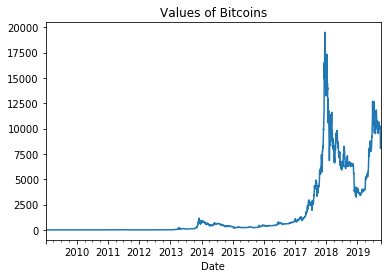

In [31]:
bitcoin['Value'].plot(title='Values of Bitcoins')


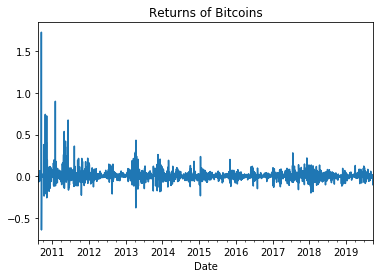

In [33]:
bitcoin['returns'].dropna().plot(title='Returns of Bitcoins')

## Daily aggregated sentiment

Compute the daily average

In [34]:
query = {"sentiment": {"$ne": "Neutral"}}
text = pd.DataFrame(list(db.messages.find(query)))
text["created_at"] = pd.to_datetime(text["created_at"], infer_datetime_format=True)
text = (text
        .set_index("created_at")
        .drop(columns="id")
        .resample("D")
        .mean()
       )

In [35]:
timeseries = pd.concat([text, bitcoin], axis = 1, join="inner")

timeseries.head()

,sentiment_,Value,returns
2019-09-02,0.883838,9621.701667,0.003141
2019-09-03,0.842254,9937.605000,0.032832
2019-09-04,0.735915,10518.406667,0.058445
2019-09-05,0.571984,10568.231667,0.004737
2019-09-06,0.630653,10559.038333,-0.000870


## Granger test

Test the Granger Causality between sentiment on social media and stock returns

### How does Granger causality test work?

It is based on the idea that if X causes Y, then the forecast of Y based on previous values of Y AND the previous values of X should outperform the forecast of Y based on previous values of Y alone.

According to Statsmodels 

The Null hypothesis for `grangercausalitytests` is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

The null hypothesis for all four test is that the coefficients corresponding to past values of the second time series are zero.

In [25]:
from statsmodels.tsa.stattools import grangercausalitytests

In [45]:
grangercausalitytests(timeseries[['returns', 'sentiment_']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1734  , p=0.0203  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=6.9451  , p=0.0084  , df=1
likelihood ratio test: chi2=6.1805  , p=0.0129  , df=1
parameter F test:         F=6.1734  , p=0.0203  , df_denom=24, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8120  , p=0.0387  , df_denom=21, df_num=2
ssr based chi2 test:   chi2=9.4392  , p=0.0089  , df=2
likelihood ratio test: chi2=8.0528  , p=0.0178  , df=2
parameter F test:         F=3.8120  , p=0.0387  , df_denom=21, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8962  , p=0.0636  , df_denom=18, df_num=3
ssr based chi2 test:   chi2=12.0675 , p=0.0072  , df=3
likelihood ratio test: chi2=9.8466  , p=0.0199  , df=3
parameter F test:         F=2.8962  , p=0.0636  , df_denom=18, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7993  , p=0.1815  , df_d

{1: ({'ssr_ftest': (6.173380311607343, 0.020337464208066095, 24.0, 1),
   'ssr_chi2test': (6.945052850558262, 0.00840513539154431, 1),
   'lrtest': (6.180468984760751, 0.012916803591802393, 1),
   'params_ftest': (6.173380311607351, 0.020337464208066012, 24.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.8120034960677853, 0.03869306090356072, 21.0, 2),
   'ssr_chi2test': (9.43924675216785, 0.008918536850265663, 2),
   'lrtest': (8.052806666272886, 0.017838373399656837, 2),
   'params_ftest': (3.812003496067782, 0.038693060903560846, 21.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.896190969989182, 0.0636132364036759, 18.0, 3),
   'ssr_chi2test': (12.067462374954925, 0.00715559976190491, 3),
   'lrtest': (9.846593374999571, 0.01991618465612495, 3),
   'params_ftest': (2.896190969989186, 0.06361323640367571, 18.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

## Regress

$$r_{i, t}=\alpha+\beta_{1} \Delta s_{1, t}+\beta_{2} \Delta s_{i, t-1}+\epsilon_{t}$$


In [51]:
timeseries['sentiment_lag'] = timeseries['sentiment_'].shift(1)

In [47]:
timeseries['L_s1'] = timeseries['sentiment_'].pct_change(1)
timeseries['L_s2'] = timeseries['sentiment_lag'].pct_change(1)
timeseries.head()

,sentiment_,Value,returns,sentiment_lag,L_s1,L_s2
2019-09-02,0.883838,9621.701667,0.003141,NaN,NaN,NaN
2019-09-03,0.842254,9937.605000,0.032832,0.883838,-0.047050,NaN
2019-09-04,0.735915,10518.406667,0.058445,0.842254,-0.126254,-0.047050
2019-09-05,0.571984,10568.231667,0.004737,0.735915,-0.222758,-0.126254
2019-09-06,0.630653,10559.038333,-0.000870,0.571984,0.102571,-0.222758


In [48]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [50]:
mod1 = smf.ols(formula='returns ~ L_s1 + L_s2', 
               data=timeseries).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.229
Date:                Sun, 29 Sep 2019   Prob (F-statistic):              0.311
Time:                        14:56:27   Log-Likelihood:                 58.148
No. Observations:                  26   AIC:                            -110.3
Df Residuals:                      23   BIC:                            -106.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0086      0.005     -1.562      0.132      -0.020       0.003
L_s1          -0.0237      0.021     -1.126      0.272      -0.067       0.020
L_s2          -0.0340      0.024     -1.398      0.175      -0.084       0.016
==============================================================================
Omnibus:                       13.096   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.479
Skew:                          -0.908   Prob(JB):                     5.89e-05
Kurtosis:                       6.832   Cond. No.                         4.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## test Lexicon L1

In [ ]:
L1 = pd.read_csv('http://www.thomas-renault.com/l1_lexicon.csv', sep = ";")
L1.sort_values(by = 'keyword').head()

In [ ]:
Word_tokenize = X_train.apply(word_tokenize) 

## Predict out of sample

In [ ]:
query ={
    "sentiment":"Neutral" 
}
X_predict = metatransformation(query = query,
                               to_train = False)

In [ ]:
predicted = text_clf.predict(X_predict)

In [ ]:
pd.concat([pd.Series(X_predict, name = 'body').reset_index(),
          pd.Series(predicted, name = 'predict')], axis = 1)

# Appendix: Details steps & analytics

## Text Analysis Operations using NLTK

We use the full set with Bullish and Bearish 

### Tokenise pandas series

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

In [ ]:
Word_tokenize = X_train.apply(word_tokenize) 

In [ ]:
Word_tokenize.head()

We need to flatten the list with NLTK

In [ ]:
flattened_list = [y for x in Word_tokenize.tolist() for y in x]

### Plot the frequency distribution

In [ ]:
fdist = FreqDist(flattened_list)

In [ ]:
fdist.plot(30,cumulative=False)
plt.show()

### TF-IDF:  Our approach

As explained in the previous post, the tf-idf vectorization of a corpus of text documents assigns each word in a document a number that is proportional to its frequency in the document and inversely proportional to the number of documents in which it occurs

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

Compute the IDFs

Compute the TFIDF score

The higher the TF*IDF score (weight), the rarer the term and vice versa.